In [2]:
# Library includes
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import random

/Users/mattbarrington/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
# Helper functions

from model_functions import *

from visualize_results import *

In [4]:
# Get the data
import requests
import zipfile
from pathlib import Path
import tqdm

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "CATANIST V1"

# Download CATANIST dataset
if image_path.is_dir():
  print(f"{image_path} already exists, skipping download...")
else:
  with open(data_path / "CATANIST V1.zip", "wb") as f:
    request = requests.get("https://github.com/mattmanb/catanomics/raw/main/data/CATANIST%20V1%20.zip")
    print(f"Downloading CATANIST zip file...")
    f.write(request.content)

  # Unzip CATANIST dataset
  with zipfile.ZipFile(data_path / "CATANIST V1.zip", "r") as zip_ref:
    print("Unzipping CATANIST data...")
    zip_ref.extractall(data_path)

data/CATANIST V1 already exists, skipping download...


In [5]:
# Examine 
import os
def walk_through_dir(dir_path):
    """Walks through dir_path, returning its contents"""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

In [6]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/CATANIST V1/train'), PosixPath('data/CATANIST V1/test'))

In [7]:
# Create any data transforms I want to try

# Simple transform (size, ToTensor)
data_transform_0 = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    # Turn the image into a torch tensor
    transforms.ToTensor(),
])

# TrivialAugmentWide
data_transform_1 = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    # Try trivialaugment
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    # Turn the image into a torch tensor
    transforms.ToTensor(),
])

# Random horizontal and verticle flips, as well as guassian blur
data_transform_2 = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomRotation(degrees=180, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=17, sigma=(0.5, 3))], p=.9),
    # transforms.GaussianBlur(kernel_size=17, sigma=(0.5, 3)),
    # Turn the image into a torch tensor
    transforms.ToTensor(),
])



### Visualize the transforms

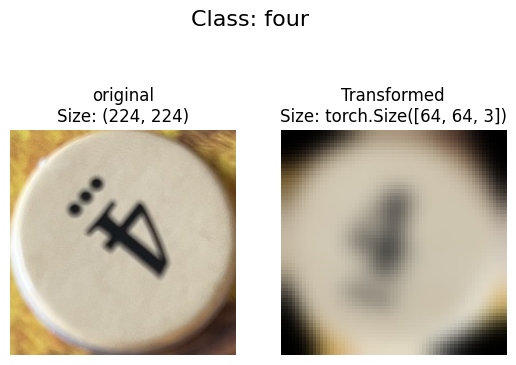

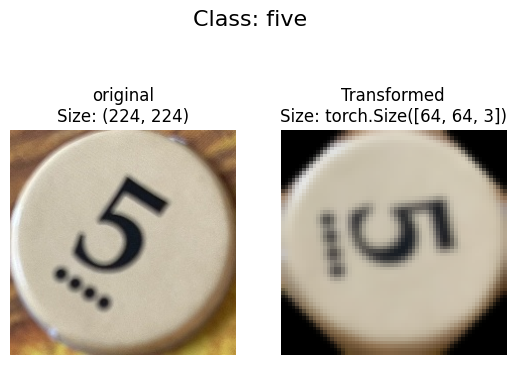

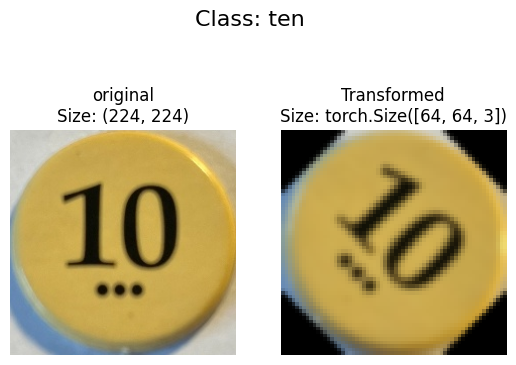

In [8]:
image_path_list = list(image_path.glob("*/*/*.jpg"))
# plot_transformed_images(image_paths=image_path_list, transform=data_transform_0, n=3)
plot_transformed_images(image_paths=image_path_list, transform=data_transform_2, n=3, seed=None)
# plot_transformed_images(image_paths=image_path_list, transform=data_transform_2, n=3)

### Create the datasets using ImageFolder

In [9]:
from torchvision import datasets

# Try different transforms here!
current_transform = data_transform_2

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=current_transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=current_transform,
                                 target_transform=None)
class_names = train_data.classes

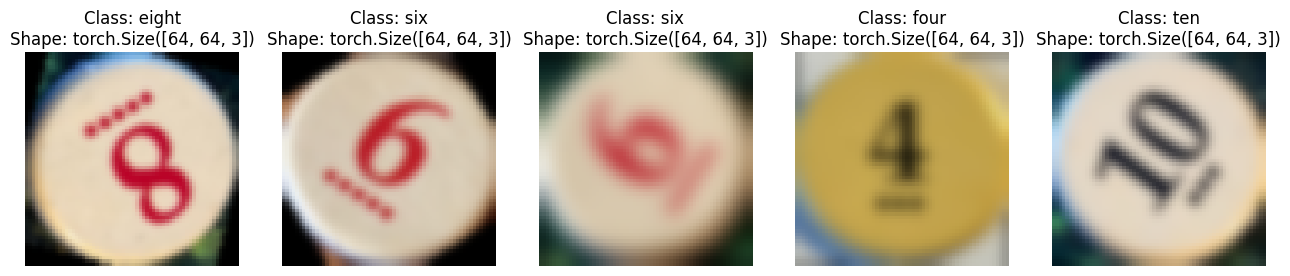

In [10]:
display_random_images(dataset=train_data, 
                      classes=class_names,
                      n=5,
                      display_shape=True)

### Create DataLoaders for the datasets

In [11]:
from torch.utils.data import DataLoader
BATCH_SIZE = 1

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x158af1c40>,
 <torch.utils.data.dataloader.DataLoader at 0x158af1e20>)

### Creating a model

In [12]:
import torch
from torch import nn

device = ("cuda" if torch.cuda.is_available()
        else "mps" if torch.backends.mps.is_available()
        else "cpu"
    )
device

'mps'

#### TinyVGG Architecture (used previously, didn't work great)

In [13]:
class TinyVGG(nn.Module):
  """
  Model architecture copying TinyVGG from CNN Explainer: https://poloclub.github.io/cnn-explainer/
  """
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3,
                     stride=2) # Default stride in a MaxPool2d layer is the kernel size
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3,
                     stride=2) # Default stride in a MaxPool2d layer is the kernel size
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*12*12, # this layer was determined by printing out shapes of previous layer in section 6.3
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(f"x shape after conv block 1: {x.shape}")
    x = self.conv_block_2(x)
    # print(f"x shape after conv block 2: {x.shape}")
    x = self.classifier(x)
    # print(f"x shape after classifier: {x.shape}")
    return x

#### CNN architecture of MNIST

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# class Simple_CNN(nn.Module):
#     def __init__(self, 
#                  input_shape:int,
#                  hidden_units:int,
#                  output_shape:int) -> None:
#         super().__init__()
#         self.conv1 = nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, padding=1) # Assuming grayscale images
#         self.bn1 = nn.BatchNorm2d(hidden_units)
#         self.conv2 = nn.Conv2d(hidden_units, hidden_units, 3, padding=1)
#         self.bn2 = nn.BatchNorm2d(hidden_units)
#         self.conv3 = nn.Conv2d(hidden_units, hidden_units, 3, padding=1)
#         self.bn3 = nn.BatchNorm2d(hidden_units)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
#         # self.fc1 = nn.Linear(hidden_units * 16 * 16, 512) # Adjust the input size based on your image size
#         # self.fc2 = nn.Linear(512, output_shape)
#         self.dropout = nn.Dropout(0.5)
#         self.flat = nn.Flatten()
#         self.out = nn.Linear(in_features=hidden_units*8*8,
#                              out_features=output_shape)

#     def forward(self, x):
#         x = self.pool(F.relu(self.bn1(self.conv1(x))))
#         # print(f"x shape after conv block 1: {x.shape}")
#         x = self.pool(F.relu(self.bn2(self.conv2(x))))
#         # print(f"x shape after conv block 2: {x.shape}")
#         x = self.pool(F.relu(self.bn3(self.conv3(x))))
#         # print(f"x shape after conv block 3: {x.shape}")
#         # x = x.view(-1, 64 * 16 * 16) # Flatten the output for the fully connected layer
#         x = self.dropout(x)
#         x = self.flat(x)
#         x = self.out(x)
#         return x


class Simple_CNN(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape:int) -> None:
        super().__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=input_shape,              
                out_channels=hidden_units,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units, 
                      kernel_size=5, 
                      stride=1, 
                      padding=2),     
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),                
        )
        # fully connected layer, output 10 classes
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16, 
                      out_features=output_shape)
        )
    def forward(self, x):
        x = self.conv1(x)
        # print(f"x shape after conv block 1: {x.shape}")
        x = self.conv2(x)
        # print(f"x shape after conv block 2: {x.shape}")
        x = self.classifier(x)
        # print(f"x shape after classifier: {x.shape}")
        return x    # return x for visualization

### ResNet Architecture

#### Define the blocks

In [15]:
class BasicBlock(nn.Module):
    def __init__(self, input_shape: int, output_shape:int, stride=1) -> None:
        super(BasicBlock, self).__init__()
        # Conv layer 1
        self.conv1 = nn.Conv2d(input_shape, 
                               output_shape, 
                               kernel_size=3,
                               stride=stride,
                               padding=1,
                               bias=False)
        # Batch norm 1
        self.bn1 = nn.BatchNorm2d(output_shape)
        # Activation
        self.relu = nn.ReLU(inplace=True)
        
        # Conv layer 2
        self.conv2 = nn.Conv2d(output_shape, 
                               output_shape,
                               kernel_size=3,
                               stride=1,
                               padding=1,
                               bias=False)
        # Batch norm 2
        self.bn2 = nn.BatchNorm2d(output_shape)
        
        # Account for differences in stride length if not 1 & num filters
        self.downsample = nn.Sequential()
        if stride != 1 or input_shape != output_shape:
            self.downsample = nn.Sequential(
                nn.Conv2d(input_shape, output_shape,
                          kernel_size=1, stride=stride,
                          bias=False),
                nn.BatchNorm2d(output_shape)
            )
    def forward(self, x):
        identity = x
        logits = self.conv1(x)
        logits = self.bn1(logits)
        logits = self.relu(logits)
        logits = self.conv2(logits)
        logits = self.bn2(logits)
        logits += self.downsample(identity)
        logits = self.relu(logits)
        return logits
        

#### Create ResNet

In [16]:
class ResNet(nn.Module):
    def __init__(self, input_shape, block, layers, class_cnt):
        super(ResNet, self).__init__()
        self.num_classes = class_cnt
        self.in_channels = 64
        self.conv1 = nn.Conv2d(in_channels=input_shape, 
                               out_channels=64, 
                               kernel_size=3, 
                               stride=1, 
                               padding=1, 
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        # Create 3 'blocks'
        self.block1 = self.make_layer(block, 64, layers[0], stride=1)
        self.block2 = self.make_layer(block, 128, layers[1], stride=2)
        self.block3 = self.make_layer(block, 256, layers[2], stride=2)
        # Average pooling
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        # Fully connected layer
        self.fc = nn.Linear(256, class_cnt)
    def make_layer(self, block, output_shape, blocks, stride):
        layers = []
        layers.append(block(self.in_channels, output_shape, stride))
        self.in_channels = output_shape
        for _ in range(1, blocks):
            layers.append(block(output_shape, output_shape, stride=1))
        return nn.Sequential(*layers)
    def forward(self, x):
        logits = self.conv1(x)
        # print(f"x shape after conv block 1: {x.shape}")
        logits = self.bn1(logits)
        # print(f"x shape after batch norm 1: {x.shape}")
        logits = self.relu(logits)
        logits = self.block1(logits)
        # print(f"x shape after res block 1: {x.shape}")
        logits = self.block2(logits)
        # print(f"x shape after res block 2: {x.shape}")
        logits = self.block3(logits)
        # print(f"x shape after res block 3: {x.shape}")
        logits = self.avg_pool(logits)
        logits = logits.view(logits.size(0), -1)
        logits = self.fc(logits)
        return logits

In [17]:
model = ResNet(input_shape=3, 
               block=BasicBlock,
               layers=[2, 2, 2],
               class_cnt=len(class_names)).to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (block1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=

In [18]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader))
image_batch.shape, label_batch.shape
model(image_batch.to(device))

tensor([[ 0.1420, -0.7884,  0.5775, -0.4827, -0.3983,  0.4183, -0.8414,  0.2976,
         -0.6700, -0.2617]], device='mps:0', grad_fn=<LinearBackward0>)

### Train the model

In [19]:
# Hyperparameters (Batch size is in cell 10)
EPOCHS = 100
INPUT_SHAPE = 3
HIDDEN_UNITS = 10
OUTPUT_SHAPE = len(class_names)
LEARNING_RATE = 0.001
LOSS_FN = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam

simple_train = False
VGG_train = False
ResNet_train = True

In [20]:
### Train simple CNN
if simple_train:
    model_simple = Simple_CNN(input_shape=INPUT_SHAPE,
                        hidden_units=HIDDEN_UNITS,
                        output_shape=OUTPUT_SHAPE).to(device)

    simple_optimizer = optimizer(params=model_simple.parameters(), lr=LEARNING_RATE)

    # Start the timer
    from timeit import default_timer as timer
    start_time = timer()

    # Train simple model
    model_simple_results = train(model=model_simple,
                                train_dataloader=train_dataloader,
                                test_dataloader=test_dataloader,
                                optimizer=simple_optimizer,
                                loss_fn=LOSS_FN,
                                epochs=EPOCHS,
                                device=device)

    # End the timer
    end_time = timer()
    print(f"Simple training time: {end_time-start_time:.3f} seconds")
else:
    print("Skipping simple CNN training for now...")

Skipping simple CNN training for now...


In [21]:
### Train VGG
if VGG_train:
    model_VGG = TinyVGG(input_shape=INPUT_SHAPE,
                        hidden_units=HIDDEN_UNITS,
                        output_shape=OUTPUT_SHAPE).to(device)

    VGG_optimizer = optimizer(params=model_VGG.parameters(), lr=LEARNING_RATE)

    # Start the timer
    from timeit import default_timer as timer
    start_time = timer()

    # Train simple model
    model_VGG_results = train(model=model_VGG,
                                train_dataloader=train_dataloader,
                                test_dataloader=test_dataloader,
                                optimizer=VGG_optimizer,
                                loss_fn=LOSS_FN,
                                epochs=EPOCHS,
                                device=device)

    # End the timer
    end_time = timer()
    print(f"VGG training time: {end_time-start_time:.3f} seconds")
else:
    print("Skipping VGG training for now...")

Skipping VGG training for now...


In [23]:
### Train ResNet
if ResNet_train:
    model_resnet = ResNet(input_shape=INPUT_SHAPE, 
                        block=BasicBlock,
                        layers=[2, 2, 2],
                        class_cnt=OUTPUT_SHAPE).to(device)

    resnet_optimizer = optimizer(model_resnet.parameters(), lr=LEARNING_RATE)

    # Start the timer
    from timeit import default_timer as timer
    start_time = timer()

    # Train simple model
    model_resnet_results = train(model=model_resnet,
                                train_dataloader=train_dataloader,
                                test_dataloader=test_dataloader,
                                optimizer=resnet_optimizer,
                                loss_fn=LOSS_FN,
                                epochs=EPOCHS,
                                device=device)

    # End the timer
    end_time = timer()
    print(f"ResNet training time: {end_time-start_time:.3f} seconds")
else:
    print("Skipping ResNet Training for now...")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.6500 | train_acc: 0.0714 | test_loss: 2.3692 | test_acc: 0.0667
Epoch: 2 | train_loss: 2.5207 | train_acc: 0.0857 | test_loss: 2.1994 | test_acc: 0.2000
Epoch: 3 | train_loss: 2.4041 | train_acc: 0.0857 | test_loss: 2.2021 | test_acc: 0.2000
Epoch: 4 | train_loss: 2.3418 | train_acc: 0.1143 | test_loss: 2.1832 | test_acc: 0.2000
Epoch: 5 | train_loss: 2.2016 | train_acc: 0.1714 | test_loss: 2.9321 | test_acc: 0.2000
Epoch: 6 | train_loss: 2.1562 | train_acc: 0.1286 | test_loss: 2.2004 | test_acc: 0.2000
Epoch: 7 | train_loss: 2.0215 | train_acc: 0.1143 | test_loss: 2.2165 | test_acc: 0.1667
Epoch: 8 | train_loss: 1.9660 | train_acc: 0.2143 | test_loss: 2.5191 | test_acc: 0.2667
Epoch: 9 | train_loss: 1.9529 | train_acc: 0.1571 | test_loss: 1.9863 | test_acc: 0.2000
Epoch: 10 | train_loss: 1.9441 | train_acc: 0.1714 | test_loss: 1.9645 | test_acc: 0.1667
Epoch: 11 | train_loss: 1.9308 | train_acc: 0.1714 | test_loss: 3.0568 | test_acc: 0.2000
Epoch: 12 | train_l

### Vertical and Horizontally Transformed with Guassian Blur:
* Epoch: 25 | train_loss: 0.9077 | train_acc: 0.6857 | test_loss: 1.1942 | test_acc: 0.5333
### No augmentation:
* Epoch: 25 | train_loss: 0.0026 | train_acc: 1.0000 | test_loss: 1.5991 | test_acc: 0.6333
### TrivialAugment:
* Epoch: 25 | train_loss: 0.9532 | train_acc: 0.7857 | test_loss: 1.9620 | test_acc: 0.4667

### Plot any loss curves

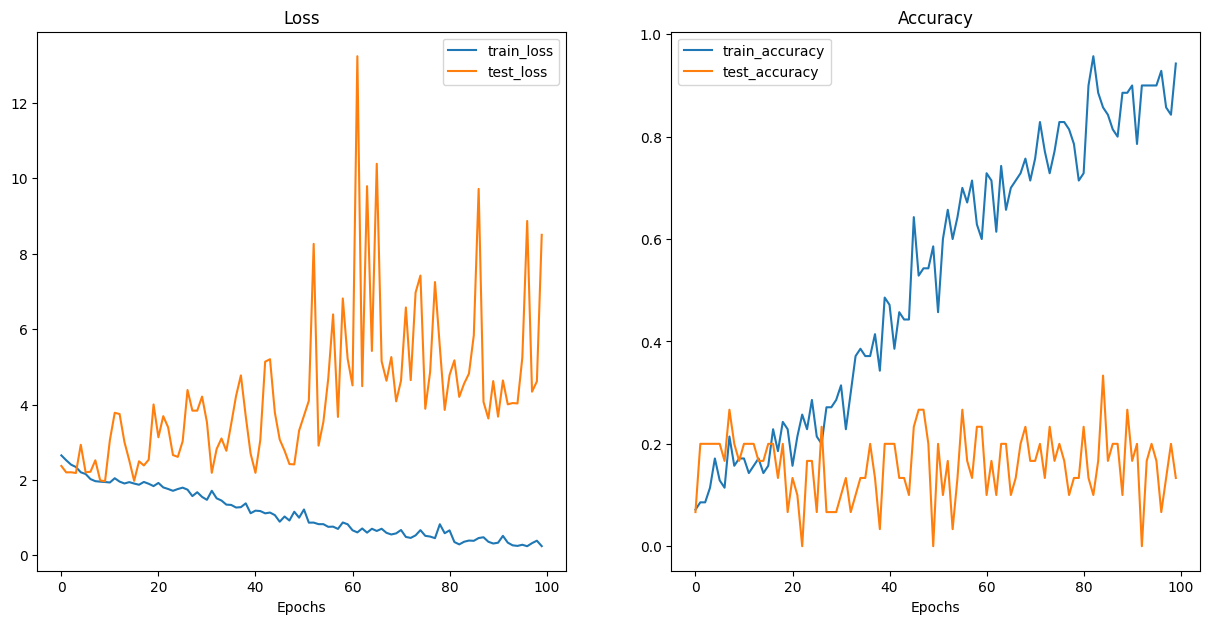

In [24]:
plot_loss_curves(model_resnet_results)
# plot_loss_curves(model_VGG_results)

### Test model on custom image

In [25]:
import torchvision
from torchvision import transforms
from PIL import Image

custom_image_path = "./condensed/CATANIST V1/eval/eight.png"
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

# Print out image data
print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Custom image tensor:
tensor([[[142, 123, 126,  ..., 132, 151, 161],
         [151, 138, 133,  ..., 135, 151, 164],
         [152, 163, 158,  ..., 143, 149, 161],
         ...,
         [155, 171, 144,  ...,  83, 109, 130],
         [155, 165, 153,  ...,  86, 106, 125],
         [153, 155, 152,  ...,  94, 106, 118]],

        [[100,  84,  86,  ...,  97, 113, 121],
         [106,  93,  90,  ...,  97, 111, 122],
         [106, 117, 114,  ..., 101, 107, 118],
         ...,
         [112, 128, 101,  ...,  61,  82,  99],
         [110, 120, 108,  ...,  64,  80,  94],
         [108, 110, 107,  ...,  71,  80,  88]],

        [[ 53,  40,  43,  ...,  52,  64,  70],
         [ 59,  49,  48,  ...,  49,  63,  71],
         [ 55,  68,  65,  ...,  51,  58,  67],
         ...,
         [ 65,  80,  54,  ...,  30,  45,  58],
         [ 62,  72,  60,  ...,  34,  46,  55],
         [ 60,  62,  59,  ...,  42,  49,  53]],

        [[255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 25

In [26]:
# Making a prediction given the image
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)
custom_image /= 255

In [27]:
from torchvision import transforms

custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
])

custom_image_transformed = custom_image_transform(custom_image[:3, :, :])

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([4, 50, 56])
New shape: torch.Size([3, 64, 64])


/Users/mattbarrington/Library/Python/3.9/lib/python/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


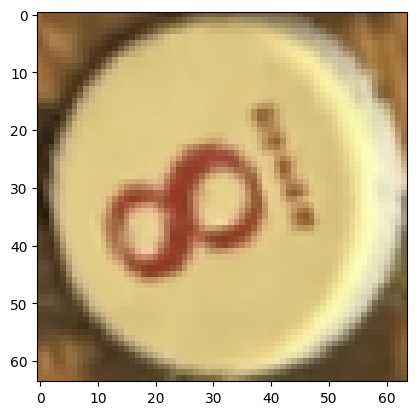

In [28]:
plt.imshow(custom_image_transformed.permute(1, 2, 0))

In [29]:
model_resnet.eval()
with torch.inference_mode():
    custom_image_pred = model(custom_image_transformed.unsqueeze(0).to(device))
custom_image_pred

tensor([[ 0.1267, -0.8538,  0.5238, -0.5361, -0.3909,  0.4114, -0.8231,  0.3058,
         -0.6813, -0.2326]], device='mps:0')

In [30]:
# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")
print(f"Prediction class: {class_names[custom_image_pred_label]}")
class_names

Prediction logits: tensor([[ 0.1267, -0.8538,  0.5238, -0.5361, -0.3909,  0.4114, -0.8231,  0.3058,
         -0.6813, -0.2326]], device='mps:0')
Prediction probabilities: tensor([[0.1245, 0.0467, 0.1852, 0.0642, 0.0742, 0.1655, 0.0482, 0.1490, 0.0555,
         0.0869]], device='mps:0')
Prediction label: tensor([2], device='mps:0')
Prediction class: five


['eight',
 'eleven',
 'five',
 'four',
 'nine',
 'six',
 'ten',
 'three',
 'twelve',
 'two']